#### Setup imports

In [1]:
import numpy as np
from monai.data.image_reader import ImageReader, ITKReader
from ipywidgets.widgets import *
import ipywidgets as widgets

import matplotlib.pyplot as plt
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    EnsureChannelFirstd,
    RandFlipd,
    RandRotated
)
import wandb
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceFocalLoss, GeneralizedDiceLoss
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, Dataset
from monai.config import print_config
from monai.apps import download_and_extract
import torch

import os
import glob
from tqdm import tqdm
import numpy as np
from monai.data import DataLoader
import os
import glob
from monai.transforms.spatial.array import Resize

from copy import deepcopy
from enum import Enum
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.networks.layers import AffineTransform
from monai.networks.layers.simplelayers import GaussianFilter
from monai.transforms.croppad.array import CenterSpatialCrop, SpatialPad
from monai.transforms.inverse import InvertibleTransform
from monai.transforms.spatial.array import (
    Resize,
)
from monai.transforms.transform import MapTransform, RandomizableTransform
from monai.transforms.utils import create_grid
from monai.utils import (
    InterpolateMode,
    ensure_tuple_rep,
)
from monai.utils.deprecate_utils import deprecated_arg
from monai.utils.enums import TraceKeys
from monai.utils.module import optional_import
from monai.utils.type_conversion import convert_data_type, convert_to_dst_type
from monai.apps import load_from_mmar
from monai.apps.mmars import RemoteMMARKeys
from monai.networks.utils import copy_model_state
from monai.optimizers import generate_param_groups
import torch.optim as optim
print_config()

MONAI version: 0.8.1
Numpy version: 1.21.5
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



#### Preprocessing

In [2]:
class InterpolateMode(Enum):
    NEAREST = "nearest"
    LINEAR = "linear"
    BILINEAR = "bilinear"
    BICUBIC = "bicubic"
    TRILINEAR = "trilinear"
    AREA = "area"


InterpolateModeSequence = Union[
    Sequence[Union[InterpolateMode, str]], InterpolateMode, str
]

class ResizedC(MapTransform, InvertibleTransform):

    backend = Resize.backend

    def __init__(
        self,
        keys: KeysCollection,
        spatial_size: Union[Sequence[int], int],
        size_mode: str = "all",
        mode: InterpolateModeSequence = InterpolateMode.AREA,
        align_corners: Union[Sequence[Optional[bool]], Optional[bool]] = None,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mode = ensure_tuple_rep(mode, len(self.keys))
        self.align_corners = ensure_tuple_rep(align_corners, len(self.keys))
        self.resizer = Resize(spatial_size=spatial_size, size_mode=size_mode)
        self.spatial_size = spatial_size

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key, mode, align_corners in self.key_iterator(
            d, self.mode, self.align_corners
        ):
            self.push_transform(
                d,
                key,
                extra_info={
                    "mode": mode.value if isinstance(mode, Enum) else mode,
                    "align_corners": align_corners
                    if align_corners is not None
                    else TraceKeys.NONE,
                },
            )
            init_slice = int(d[key].shape[-1]*0.15)
            end_slice = int(d[key].shape[-1]*0.1)
            # Reduce Size in Memory
            if key == "label":
                d[key] = d[key].astype(np.int8)
                if d[key].shape[-1] > 600: d[key] = d[key][:,:,:,init_slice:-end_slice] #

                if d["image_meta_dict"].get("PatientName", None) and d["image_meta_dict"]["PatientName"].startswith("NI") and len(d[key].shape) != 4:
                    # print(d[key].shape)
                    liver_channel = np.where((d[key] != 6), 0, d[key])
                    liver_channel = np.where((liver_channel == 6), 1, liver_channel)
                    # liver_channel = np.expand_dims(liver_channel, 0)
                    w, h, z = self.spatial_size
                    liver_channel = self.resizer(liver_channel, align_corners=align_corners)
                    background = np.ones((1, z, w, h), dtype=np.float16) - liver_channel
                    empty_injures = np.zeros((1, z, w, h), dtype=np.float16)
                    resized = [background, liver_channel, empty_injures]
                    d[key] = np.stack(resized).astype(np.int8).squeeze()

                else:
                    label = d[key]
                    w, h, z = self.spatial_size
                    resized = list()
                    background = np.ones((1, w, h, z), dtype=np.int8)
                    for i, channel in enumerate([0, 2]):  # TODO: desharcodead
                        resized.append(
                            self.resizer(
                                np.expand_dims(label[channel, :, :, :], 0),
                                align_corners=align_corners,
                            )
                        )

                    background -= resized[0] # + resized[1]
                    resized = [background] + resized
                    d[key] = np.stack(resized).astype(np.int8).squeeze()
            else:
                if d[key].shape[-1] > 600: d[key] = d[key][:,:,:,init_slice:-end_slice]
                d[key] = self.resizer(d[key], align_corners=align_corners)

        keys = ['spacing', 'original_affine', 'affine', 'spatial_shape', 'original_channel_dim', 'filename_or_obj']
        new_label_metadata = dict()
        for key in keys:
            new_label_metadata[key] = d["label_meta_dict"].get(key, 0)

        d["label_meta_dict"] = new_label_metadata

        if "PatientID" not in d["image_meta_dict"]:
            d["image_meta_dict"]["PatientID"] = "0"
        if "PatientName" not in d["image_meta_dict"]:
            d["image_meta_dict"]["PatientName"] = "0"
        if "SliceThickness" not in d["image_meta_dict"]:
            d["image_meta_dict"]["SliceThickness"] = "0"
        return d

    def inverse(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            orig_size = transform[TraceKeys.ORIG_SIZE]
            mode = transform[TraceKeys.EXTRA_INFO]["mode"]
            align_corners = transform[TraceKeys.EXTRA_INFO]["align_corners"]
            # Create inverse transform
            inverse_transform = Resize(
                spatial_size=orig_size,
                mode=mode,
                align_corners=None
                if align_corners == TraceKeys.NONE
                else align_corners,
            )
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [3]:
class adaptOverlay(MapTransform, InvertibleTransform):

    backend = Resize.backend

    def __init__(
        self,
        keys: KeysCollection,
        size_mode: str = "all",
        mode: InterpolateModeSequence = InterpolateMode.AREA,
        align_corners: Union[Sequence[Optional[bool]], Optional[bool]] = None,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.mode = ensure_tuple_rep(mode, len(self.keys))
        self.align_corners = ensure_tuple_rep(align_corners, len(self.keys))

    def __adapt_overlay__(self, overlay_path, mha_path, label):
        import SimpleITK as sitk
        if label.shape[-1] == 6:
            return label
        # Load the mha
        mha_data = sitk.ReadImage(mha_path)
        mha_org = mha_data.GetOrigin()[-1]
        # Load the mha image
        mha_img = sitk.GetArrayFromImage(mha_data)
        original_z_size = mha_img.shape[0]

        # Load the overlay
        overlay_data = sitk.ReadImage(overlay_path)
        overlay_org = overlay_data.GetOrigin()[-1]

        overlay_init = np.abs(1/mha_data.GetSpacing()[-1]*(mha_org-overlay_org) )

        lower_bound = int(overlay_init)
        upper_bound = label.shape[-1]
        zeros_up = lower_bound
        zeros_down = original_z_size - (upper_bound + lower_bound)
        new = list()

        if zeros_up > 0:
            new.append(np.zeros((label.shape[0], label.shape[1], zeros_up), dtype=label.dtype))

        new.append(label)

        if zeros_down > 0:
            new.append(np.zeros((label.shape[0], label.shape[1], zeros_down), dtype=label.dtype))

        label = np.concatenate(new, axis=2)

        return label


    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key, mode, align_corners in self.key_iterator(
            d, self.mode, self.align_corners
        ):
            self.push_transform(
                d,
                key,
                extra_info={
                    "mode": mode.value if isinstance(mode, Enum) else mode,
                    "align_corners": align_corners
                    if align_corners is not None
                    else TraceKeys.NONE,
                },
            )
            # Reduce Size in Memory
            if key == "label":
                d[key] = d[key].astype(np.int8)
                if d["image_meta_dict"].get("PatientName", None) and d["image_meta_dict"]["PatientName"].startswith("NI"):
                    file_path = d["label_meta_dict"]["filename_or_obj"]
                    data_path = d["image_meta_dict"]["filename_or_obj"]
                    d[key] = self.__adapt_overlay__(file_path, data_path, d[key])
        return d

    def inverse(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            transform = self.get_most_recent_transform(d, key)
            orig_size = transform[TraceKeys.ORIG_SIZE]
            mode = transform[TraceKeys.EXTRA_INFO]["mode"]
            align_corners = transform[TraceKeys.EXTRA_INFO]["align_corners"]
            # Create inverse transform
            inverse_transform = Resize(
                spatial_size=orig_size,
                mode=mode,
                align_corners=None
                if align_corners == TraceKeys.NONE
                else align_corners,
            )
            # Apply inverse transform
            d[key] = inverse_transform(d[key])
            # Remove the applied transform
            self.pop_transform(d, key)

        return d

In [4]:
class RemoveDicts(MapTransform, InvertibleTransform):

    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            self.push_transform(d, key)
        # print( f"image shape: {d['image'].shape}")
        # print( f"label shape: {d['label'].shape}")
        # print(f"path name: {d['image_meta_dict']['filename_or_obj']}")
        a = {"image": d["image"], "label": d["label"], "path": d["image_meta_dict"]["filename_or_obj"]}
        d = a
        return d

    def inverse(self, data: Mapping[Hashable, Any]) -> Dict[Hashable, Any]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            d[key] = d[key]
            # Remove the applied transform
            self.pop_transform(d, key)
        return d


#### Flags

In [31]:
PRETRAINED = True
TRANSFER_LEARNING = True

#### Define the LightningModule

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "spleen_data"
print(root_dir)

spleen_data


In [20]:
class Net(pytorch_lightning.LightningModule):
    def __init__(self, train_img_size, val_img_size):
        super().__init__()
        self.train_img_size = train_img_size
        self.val_img_size = val_img_size
        if PRETRAINED:
            print("using a pretrained model.")
            unet_model = load_from_mmar(
                item=mmar[RemoteMMARKeys.NAME],
                mmar_dir=root_dir,
                # map_location=device,
                pretrained=True,
            )
            self._model = unet_model
            # copy all the pretrained weights except for variables whose name matches "model.0.conv.unit0"
            if TRANSFER_LEARNING:
                pretrained_dict, updated_keys, unchanged_keys = copy_model_state(
                    self._model, unet_model,#  exclude_vars="model.[0-2].conv.unit[0-3]"
                )
                print(
                    "num. var. using the pretrained",
                    len(updated_keys),
                    ", random init",
                    len(unchanged_keys),
                    "variables.",
                )
                self._model.load_state_dict(pretrained_dict)
                # stop gradients for the pretrained weights
                for x in self._model.named_parameters():
                    if x[0] in updated_keys:
                        x[1].requires_grad = True
                params = generate_param_groups(
                    network=self._model,
                    layer_matches=[lambda x: x[0] in updated_keys],
                    match_types=["filter"],
                    lr_values=[1e-4],
                    include_others=False,
                )
                self.params = params

        else:
            self._model = UNet(
                spatial_dims=3,
                in_channels=1,
                out_channels=2,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
                norm=Norm.BATCH,
            )
        self.loss_function = DiceFocalLoss(
            softmax=True, include_background=False, smooth_dr=1e-7, smooth_nr=1e-7
        )
        self.post_pred = Compose(
            [EnsureType("tensor", device="cpu"), AsDiscrete(argmax=True, to_onehot=2)]
        )
        self.post_label = Compose(
            [EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)]
        )
        self.dice_metric = DiceMetric(include_background=False, reduction="mean")
        self.best_val_dice = 0
        self.best_val_epoch = 0

    def prepare_data(self):
        # set up the correct data path
        train_images = sorted(
            glob.glob(
                os.path.join(
                    "U:", "\lauraalvarez", "data", "liver", "train", "scans", "*.mha"
                )
            )
        )
        train_labels = sorted(
            glob.glob(
                os.path.join(
                    "U:", "\lauraalvarez", "data", "liver", "train", "overlays", "*.mha"
                )
            )
        )  # U:\lauraalvarez\data\overlays\overlay_results\overlay_results\liver\train
        # from sklearn.utils import shuffle
        # train_images, train_labels = shuffle(np.array(train_images), np.array(train_labels))   
       
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(train_images, train_labels)
        ]
        train_files, val_files = data_dicts[:-7], data_dicts[-7:]
        print("validation files", val_files)
        print("training files", train_files)
        print("len(train_files)", len(train_files))

        # set deterministic training for reproducibility
        set_determinism(seed=0)

        # define the data transforms

        train_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"], reader=ITKReader),
                adaptOverlay(keys=["label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                # CropForegroundd(keys=["image", "label"], source_key="image"),
                # Spacingd(
                #     keys=["image", "label"],
                #     pixdim=(1.5, 1.5, 2.0),
                #     mode=("bilinear", "nearest"),
                # ),
                ResizedC(keys=["image", "label"], spatial_size=self.train_img_size),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
                # RandRotated(keys=["image", "label"], range_x=(-15, 15), range_y=(-15, 15), range_z=(-15, 15)),
                RemoveDicts(keys=["image", "label"]),
            ]
        )

        # define the data transforms
        val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"], reader=ITKReader),
                adaptOverlay(keys=["image", "label"]),
                EnsureChannelFirstd(keys=["image", "label"]),
                Orientationd(keys=["image", "label"], axcodes="RAS"),
                # Spacingd(
                #     keys=["image", "label"],
                #     pixdim=(1.5, 1.5, 2.0),
                #     mode=("bilinear", "nearest"),
                # ),
                ResizedC(keys=["image", "label"], spatial_size=self.val_img_size),
                ScaleIntensityRanged(
                    keys=["image"],
                    a_min=-57,
                    a_max=164,
                    b_min=0.0,
                    b_max=1.0,
                    clip=True,
                ),
            ]
        )

        self.train_ds = CacheDataset(
            data=train_files,
            transform=train_transforms,
            cache_rate=0,
            num_workers=4,
        )

        self.val_ds = CacheDataset(
            data=val_files,
            transform=val_transforms,
            cache_rate=0,
            num_workers=4,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        if PRETRAINED:
            optimizer = torch.optim.Adam(self.params, lr=5e-4, weight_decay=1e-4)
        return optimizer

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.train_ds, batch_size=2, shuffle=True, num_workers=0
        )
        return train_loader

    def val_dataloader(self):
        val_loader = torch.utils.data.DataLoader(
            self.val_ds, batch_size=1, shuffle=False, num_workers=0
        )
        return val_loader

    def forward(self, x):
        return self._model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        #  the function is called after every epoch is completed

        # calculating average loss
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()

        # logging using tensorboard logger
        self.log("dice loss", avg_loss)
        lnp.lnp(f"Dice Loss: {avg_loss}")

        self.logger.experiment.log({"dice loss": avg_loss})

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=3)])
        post_label = Compose([EnsureType(), AsDiscrete()])
        roi_size = (160, 160, 160)
        sw_batch_size = 2
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward
        )
        predicition ={"output": outputs, "image": images, "label": labels}
        outputs = [post_pred(i) for i in decollate_batch(outputs)]

        # if batch_idx % 2 == 0:
        # self.logger.experiment.log({"DICOM gif": wandb.Image(img_path), "epoch": self.current_epoch})

        labels = [
            post_label(torch.unsqueeze(i, 0)).squeeze() for i in decollate_batch(labels)
        ]
        dice_metric = self.dice_metric(y_pred=outputs, y=labels)
        # figure = computeROC(predicition)
        # self.logger.experiment.log({"ROC": figure, "epoch": self.current_epoch})
        return {"dice_metric": dice_metric, "val_number": len(outputs), "prediction": predicition}

    def _convert2Class(self, y_pred):
        return torch.max(y_pred, dim=1)

    def validation_epoch_end(self, outputs):
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        tensorboard_logs = {
            "dice_metric": mean_val_dice,
        }

        predictions = [x["prediction"] for x in outputs]
        

        # class_labels = [torch.max(x["label"] , 1)[0] for x in predictions]
        # print(class_labels[0].shape)

        path_gif = make_gif(predictions)
        self.logger.experiment.log({"DICOM gif": wandb.Image(path_gif)})
            
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        self.log("dice_metric", mean_val_dice)
        return {"log": tensorboard_logs}


In [8]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_liver_and_tumor_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_liver_and_tumor_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

def save_checkpoint(state, name):
    file_path = "checkpoints/"
    if not os.path.exists(file_path): 
        os.makedirs(file_path)
    epoch = state["epoch"]
    save_dir = file_path + name + str(epoch)
    torch.save(state, save_dir)
    print(f"Saving checkpoint for epoch {epoch} in: {save_dir}")

def save_state_dict(state, name):
    file_path = "checkpoints/"
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    save_dir = file_path + f"{name}_best"
    torch.save(state, save_dir)
    print(f"Best accuracy so far. Saving model to:{save_dir}")

In [21]:
import time


class Log_and_print:
    def __init__(self, run_name, tb_logger=None):
        self.tb_logger = tb_logger
        self.run_name = run_name
        self.str_log = "run_name" + "\n  \n"

    def lnp(self, tag):
        print(self.run_name, time.asctime(), tag)
        self.str_log += str(time.asctime()) + " " + str(tag) + "  \n"

    def dump_to_tensorboard(self):
        if not self.tb_logger:
            print("No tensorboard logger")
        self.tb_logger.experiment.add_text("log", self.str_log)

## Create Gif Function

In [22]:
from monai.visualize import matshow3d, blend_images
import imageio
def make_gif(predictions):
    volumes = []
    for prediction in predictions:
        selected = prediction

        pred = torch.argmax(selected['output'], dim=1).detach().cpu().numpy()
        true_label = torch.sum(selected['label'][:,1:,:,:,:], dim=1).detach().cpu().numpy()
        image = selected['image'][0].cpu().numpy()

        blended_true_label = blend_images(image, true_label)
        blended_final_true_label = torch.from_numpy(blended_true_label).permute(1,2,0,3)

        blended_prediction = blend_images(image, pred)
        blended_final_prediction = torch.from_numpy(blended_prediction).permute(1,2,0,3)

        volume_pred = blended_final_prediction[:,:,:,:]
        volume_label = blended_final_true_label[:,:,:,:]
        volume_pred = np.squeeze(volume_pred).permute(3,0,1,2)
        volume_label = np.squeeze(volume_label).permute(3,0,1,2)
        volume = torch.hstack((volume_pred, volume_label)).numpy()
        volumes.append(volume)
    volume = np.hstack((volumes))
    data = volume.astype(np.float64) / np.max(volume) # normalize the data to 0 - 1
    data = 255 * data # Now scale by 255
    volume = data.astype(np.uint8)
    path_to_gif = f'gifs\\prediction.gif'
    if not os.path.exists("gifs\\"):
        os.mkdir("gifs\\")
    imageio.mimsave(path_to_gif, volume)
    return path_to_gif

In [23]:
def computeROC(predicition):
    pred = torch.argmax(predicition['output'], dim=1).detach().cpu().numpy()
    label = torch.sum(predicition['label'][:,1:,:,:,:], dim=1).detach().cpu().numpy()
    from sklearn.metrics import roc_curve, auc # roc curve tools
    ground_truth_labels = label.ravel() # we want to make them into vectors|
    score_value = 1-pred.ravel()/255.0 # we want to make them into vectors
    fpr, tpr, _ = roc_curve(ground_truth_labels,score_value)
    roc_auc = auc(fpr,tpr)

    fig, ax = plt.subplots(1,1)
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    return fig

## Run the training

### Variables

In [24]:
SEED = 0
IMG_SIZE = (160,160,160)
VAL_SIZE = (256,256,256)
SAVE_PATH = "lightning_logs/"
run_idx = len(os.listdir("wandb"))
RUN_NAME = f"Segmentation_{run_idx+1}"
pytorch_lightning.seed_everything(SEED)

Global seed set to 0


0

### Loggers

In [25]:
try:
    wandb.finish()
except:
    print("Wandb not initialized")

In [26]:
lnp = Log_and_print(RUN_NAME)
lnp.lnp("Loggers start")
lnp.lnp("ts_script: " + str(time.time()))

# Start Wandb
wandb_logger = pytorch_lightning.loggers.WandbLogger(
    project="traumaIA",
    # save_dir=SAVE_DIR + "log/",
    name=RUN_NAME,
    # version="fixed_version",
    # sync_tensorboard=True,
)

Segmentation_61 Tue May 24 18:26:07 2022 Loggers start
Segmentation_61 Tue May 24 18:26:07 2022 ts_script: 1653409567.304779


### CALLBACKS

In [27]:
from pl_bolts.callbacks import PrintTableMetricsCallback

In [32]:
lnp.lnp("MAIN callbacks")
l_callbacks = []
cbEarlyStopping = pytorch_lightning.callbacks.early_stopping.EarlyStopping(
    monitor="dice_metric", patience=30, mode="max"
)
l_callbacks.append(cbEarlyStopping)


checkpoint_dirpath = SAVE_PATH + "checkpoints/"
checkpoint_filename = SAVE_PATH[:-1] + "_" + RUN_NAME
lnp.lnp("checkpoint_dirpath: " + checkpoint_dirpath)
lnp.lnp("checkpoint_filename: " + checkpoint_filename)
cbModelCheckpoint = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor="dice_metric", mode="max", dirpath=checkpoint_dirpath, filename=checkpoint_filename, 
)
l_callbacks.append(cbModelCheckpoint)

l_callbacks.append(PrintTableMetricsCallback())

Segmentation_61 Tue May 24 18:35:09 2022 MAIN callbacks
Segmentation_61 Tue May 24 18:35:09 2022 checkpoint_dirpath: lightning_logs/checkpoints/
Segmentation_61 Tue May 24 18:35:09 2022 checkpoint_filename: lightning_logs_Segmentation_61


In [33]:
# initialise the LightningModule
lnp.lnp(" Start Trainining process...")
net = Net(train_img_size=IMG_SIZE, val_img_size=VAL_SIZE).load_from_checkpoint("lightning_logs\checkpoints\lightning_logs_Segmentation_14.ckpt", train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)
wandb_logger.watch(net)

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)

# initialise Lightning's trainer.
# trainer = pytorch_lightning.Trainer(
#     gpus=[0],
#     max_epochs=40,
#     logger=wandb_logger,
#     enable_checkpointing=True,
#     num_sanity_val_steps=1,
#     log_every_n_steps=1,
#     callbacks=l_callbacks,
# )

# train
# trainer.fit(net)
# wandb.finish()

Segmentation_61 Tue May 24 18:35:32 2022  Start Trainining process...
using a pretrained model.
2022-05-24 18:35:34,430 - INFO - Expected md5 is None, skip md5 check for file spleen_data\clara_pt_liver_and_tumor_ct_segmentation_4.1.zip.
2022-05-24 18:35:34,431 - INFO - File exists: spleen_data\clara_pt_liver_and_tumor_ct_segmentation_4.1.zip, skipped downloading.
2022-05-24 18:35:34,433 - INFO - Non-empty folder exists in spleen_data\clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-05-24 18:35:34,434 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at spleen_data\clara_pt_liver_and_tumor_ct_segmentation.
2022-05-24 18:35:34,498 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-05-24 18:35:34,533 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-05-24 18:35:34,550 - INFO - 
---
2022-05-24 18:35:34,551 - 

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


'dst' model updated: 148 of 148 variables.
num. var. using the pretrained 148 , random init 0 variables.


In [34]:
# initialise the LightningModule
lnp.lnp(" Start Trainining process...")
net = Net(train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)#.load_from_checkpoint("lightning_logs\checkpoints\lightning_logs_Segmentation_14.ckpt", train_img_size=IMG_SIZE, val_img_size=VAL_SIZE)
wandb_logger.watch(net)

# set up loggers and checkpoints
log_dir = os.path.join(root_dir, "logs")
# tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
#     save_dir=log_dir
# )

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=[0],
    max_epochs=40,
    logger=wandb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    callbacks=l_callbacks,
)

# train
trainer.fit(net)
wandb.finish()

Segmentation_61 Tue May 24 18:35:44 2022  Start Trainining process...
using a pretrained model.
2022-05-24 18:35:46,410 - INFO - Expected md5 is None, skip md5 check for file spleen_data\clara_pt_liver_and_tumor_ct_segmentation_4.1.zip.
2022-05-24 18:35:46,411 - INFO - File exists: spleen_data\clara_pt_liver_and_tumor_ct_segmentation_4.1.zip, skipped downloading.
2022-05-24 18:35:46,413 - INFO - Non-empty folder exists in spleen_data\clara_pt_liver_and_tumor_ct_segmentation, skipped extracting.
2022-05-24 18:35:46,415 - INFO - 
*** "clara_pt_liver_and_tumor_ct_segmentation" available at spleen_data\clara_pt_liver_and_tumor_ct_segmentation.
2022-05-24 18:35:46,518 - INFO - *** Model: <class 'monai.networks.nets.unet.UNet'>
2022-05-24 18:35:46,554 - INFO - *** Model params: {'dimensions': 3, 'in_channels': 1, 'out_channels': 3, 'channels': [16, 32, 64, 128, 256], 'strides': [2, 2, 2, 2], 'num_res_units': 2, 'norm': 'batch'}
2022-05-24 18:35:46,577 - INFO - 
---
2022-05-24 18:35:46,579 - 

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                | Params
------------------------------------------------------
0 | _model        | UNet                | 4.8 M 
1 | loss_function | GeneralizedDiceLoss | 0     
------------------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.240    Total estimated model params size (MB)


validation files [{'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111104.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110102.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111123.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110105.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111202.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110111.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111330.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110120.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111403.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110121.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111428.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110123.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111430.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324


current epoch: 0 current mean dice: 0.2175
best mean dice: 0.2175 at epoch: 0
Segmentation_61 Tue May 24 18:59:09 2022 Dice Loss: 0.9040749073028564


dice_metric
───────────
0.21749626100063324
0.21749626100063324


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259


current epoch: 1 current mean dice: 0.1933
best mean dice: 0.2175 at epoch: 0
Segmentation_61 Tue May 24 19:22:24 2022 Dice Loss: 0.8674864768981934


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993


current epoch: 2 current mean dice: 0.2114
best mean dice: 0.2175 at epoch: 0
Segmentation_61 Tue May 24 19:45:34 2022 Dice Loss: 0.869329571723938


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242


current epoch: 3 current mean dice: 0.2294
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 20:08:47 2022 Dice Loss: 0.8563817739486694


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956


current epoch: 4 current mean dice: 0.2176
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 20:31:26 2022 Dice Loss: 0.8481508493423462


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553


current epoch: 5 current mean dice: 0.2150
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 20:53:46 2022 Dice Loss: 0.8390387296676636


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045


current epoch: 6 current mean dice: 0.2260
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 21:16:52 2022 Dice Loss: 0.8232066035270691


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925


current epoch: 7 current mean dice: 0.2193
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 21:39:58 2022 Dice Loss: 0.8137138485908508


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742


current epoch: 8 current mean dice: 0.2189
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 22:03:04 2022 Dice Loss: 0.814905047416687


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465


current epoch: 9 current mean dice: 0.2176
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 22:26:06 2022 Dice Loss: 0.8021276593208313


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772


current epoch: 10 current mean dice: 0.2198
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 22:49:14 2022 Dice Loss: 0.8010357618331909


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433


current epoch: 11 current mean dice: 0.2288
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 23:12:17 2022 Dice Loss: 0.788494348526001


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.228832

current epoch: 12 current mean dice: 0.2177
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 23:35:20 2022 Dice Loss: 0.770350456237793


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.219791

current epoch: 13 current mean dice: 0.2260
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Tue May 24 23:58:08 2022 Dice Loss: 0.7777165174484253


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.217576

current epoch: 14 current mean dice: 0.2291
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Wed May 25 00:20:19 2022 Dice Loss: 0.7708677649497986


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.218912

current epoch: 15 current mean dice: 0.2279
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Wed May 25 00:42:29 2022 Dice Loss: 0.7660506367683411


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.219336

current epoch: 16 current mean dice: 0.2154
best mean dice: 0.2294 at epoch: 3
Segmentation_61 Wed May 25 01:04:43 2022 Dice Loss: 0.760671079158783


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214


current epoch: 17 current mean dice: 0.2310
best mean dice: 0.2310 at epoch: 17
Segmentation_61 Wed May 25 01:26:53 2022 Dice Loss: 0.752257227897644


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587

current epoch: 18 current mean dice: 0.2289
best mean dice: 0.2310 at epoch: 17
Segmentation_61 Wed May 25 01:49:07 2022 Dice Loss: 0.7262123823165894


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.21764

current epoch: 19 current mean dice: 0.2306
best mean dice: 0.2310 at epoch: 17
Segmentation_61 Wed May 25 02:11:16 2022 Dice Loss: 0.7244249582290649


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935

current epoch: 20 current mean dice: 0.2224
best mean dice: 0.2310 at epoch: 17
Segmentation_61 Wed May 25 02:33:26 2022 Dice Loss: 0.7300853729248047


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.211361

current epoch: 21 current mean dice: 0.2299
best mean dice: 0.2310 at epoch: 17
Segmentation_61 Wed May 25 02:55:33 2022 Dice Loss: 0.7266034483909607


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105


current epoch: 22 current mean dice: 0.2321
best mean dice: 0.2321 at epoch: 22
Segmentation_61 Wed May 25 03:17:38 2022 Dice Loss: 0.7108165621757507


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
dice_metric
───────────
0.21749626100063324
0.2174

current epoch: 23 current mean dice: 0.2238
best mean dice: 0.2321 at epoch: 22
Segmentation_61 Wed May 25 03:39:45 2022 Dice Loss: 0.6890860199928284


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
dice_metri

current epoch: 24 current mean dice: 0.2290
best mean dice: 0.2321 at epoch: 22
Segmentation_61 Wed May 25 04:01:50 2022 Dice Loss: 0.7043995261192322


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 25 current mean dice: 0.2161
best mean dice: 0.2321 at epoch: 22
Segmentation_61 Wed May 25 04:23:56 2022 Dice Loss: 0.6991722583770752


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 26 current mean dice: 0.2334
best mean dice: 0.2334 at epoch: 26
Segmentation_61 Wed May 25 04:46:07 2022 Dice Loss: 0.6730059385299683


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 27 current mean dice: 0.1989
best mean dice: 0.2334 at epoch: 26
Segmentation_61 Wed May 25 05:08:14 2022 Dice Loss: 0.7012577056884766


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 28 current mean dice: 0.2238
best mean dice: 0.2334 at epoch: 26
Segmentation_61 Wed May 25 05:30:24 2022 Dice Loss: 0.695668637752533


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 29 current mean dice: 0.2120
best mean dice: 0.2334 at epoch: 26
Segmentation_61 Wed May 25 05:52:35 2022 Dice Loss: 0.7042747735977173


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 30 current mean dice: 0.2367
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 06:14:46 2022 Dice Loss: 0.7028259634971619


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 31 current mean dice: 0.2309
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 06:36:55 2022 Dice Loss: 0.7033256888389587


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 32 current mean dice: 0.2307
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 06:59:04 2022 Dice Loss: 0.6837400794029236


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 33 current mean dice: 0.2360
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 07:21:11 2022 Dice Loss: 0.6943361759185791


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 34 current mean dice: 0.2347
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 07:43:17 2022 Dice Loss: 0.6850214600563049


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 35 current mean dice: 0.1702
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 08:05:28 2022 Dice Loss: 0.6850327849388123


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 36 current mean dice: 0.2362
best mean dice: 0.2367 at epoch: 30
Segmentation_61 Wed May 25 08:27:37 2022 Dice Loss: 0.7116494178771973


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 37 current mean dice: 0.2380
best mean dice: 0.2380 at epoch: 37
Segmentation_61 Wed May 25 08:49:47 2022 Dice Loss: 0.6580438613891602


dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 38 current mean dice: 0.2298
best mean dice: 0.2380 at epoch: 37
Segmentation_61 Wed May 25 09:11:58 2022 Dice Loss: 0.6765668988227844


Validating: 0it [00:00, ?it/s]

dice_metric
───────────
0.21749626100063324
0.21749626100063324
0.1933170109987259
0.1933170109987259
0.2113616168498993
0.2113616168498993
0.22935554385185242
0.22935554385185242
0.2176445722579956
0.2176445722579956
0.2149587720632553
0.2149587720632553
0.22598884999752045
0.22598884999752045
0.21933600306510925
0.21933600306510925
0.21891222894191742
0.21891222894191742
0.21757616102695465
0.21757616102695465
0.21979118883609772
0.21979118883609772
0.22883258759975433
0.22883258759975433
0.21771374344825745
0.21771374344825745
0.22604341804981232
0.22604341804981232
0.22911927103996277
0.22911927103996277
0.22792519629001617
0.22792519629001617
0.21543781459331512
0.21543781459331512
0.2310389280319214
0.2310389280319214
0.22888408601284027
0.22888408601284027
0.23064398765563965
0.23064398765563965
0.2224225252866745
0.2224225252866745
0.2299211025238037
0.2299211025238037
0.23211608827114105
0.23211608827114105
0.22382481396198273
0.22382481396198273
0.22899775207042694
0.22899775

current epoch: 39 current mean dice: 0.2263
best mean dice: 0.2380 at epoch: 37
Segmentation_61 Wed May 25 09:34:07 2022 Dice Loss: 0.6426970362663269



dice loss,█▇▇▇▇▆▆▆▆▅▅▅▄▅▄▄▄▄▃▃▃▃▃▂▃▃▂▃▂▃▃▃▂▂▂▂▃▁▂▁
dice_metric,▆▃▅▇▆▆▇▆▆▆▆▇▆▇▇▇▆▇▇▇▆▇▇▇▇▆█▄▇▅█▇▇██▁██▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
dice loss,0.6427
dice_metric,0.2263
epoch,39
trainer/global_step,719


In [ ]:
#  Run learning rate finder
lr_finder = trainer.tuner.lr_find(net)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()      

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
net.hparams.lr = new_lr

# Fit model
trainer.fit(net)

In [17]:
trainer.validate(net)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation files [{'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI110316.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\NI110316.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI110283.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\NI110283.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\L110130.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110130.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\L110084.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110084.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\NI111428.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\NI111428.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\L110067.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\overlays\\L110067.mha'}, {'image': 'U:\\lauraalvarez\\data\\liver\\train\\scans\\L110016.mha', 'label': 'U:\\lauraalvarez\\data\\liver\\train\\

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Validating: 0it [00:00, ?it/s]

y should be a binarized tensor.
dice_metric
───────────
0.6716417074203491


current epoch: 0 current mean dice: 0.6716
best mean dice: 0.6716 at epoch: 0
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'dice_metric': 0.6716417074203491}
--------------------------------------------------------------------------------


[{'dice_metric': 0.6716417074203491}]

In [8]:
print(
    f"train completed, best_metric: {net.best_val_dice:.4f} "
    f"at epoch {net.best_val_epoch}")

train completed, best_metric: 0.0686 at epoch 2


## View training in tensorboard

In [27]:
%load_ext tensorboard
%tensorboard --logdir=$log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 9976), started 1:08:40 ago. (Use '!kill 9976' to kill it.)

image shape torch.Size([1, 1, 226, 157, 113])
label shape torch.Size([1, 1, 226, 157, 113])


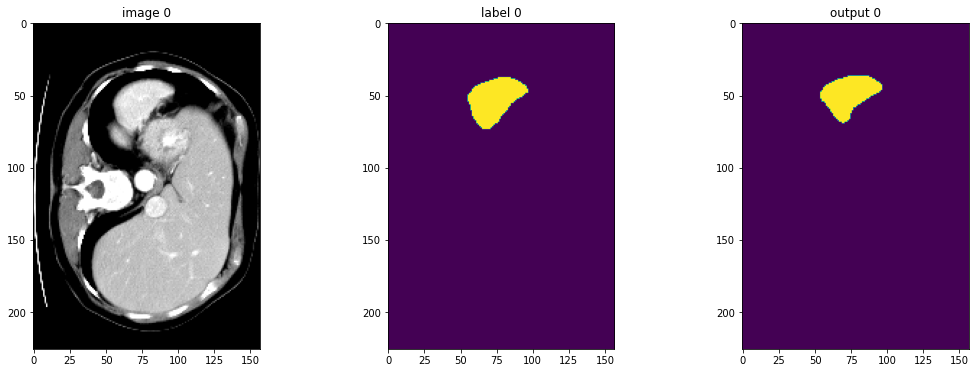

In [30]:
import numpy as np
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        print('image shape', np.shape(val_data["image"]))
        print('label shape', np.shape(val_data["label"]))
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 85], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 85])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        break

## Check best model output with the input image and label

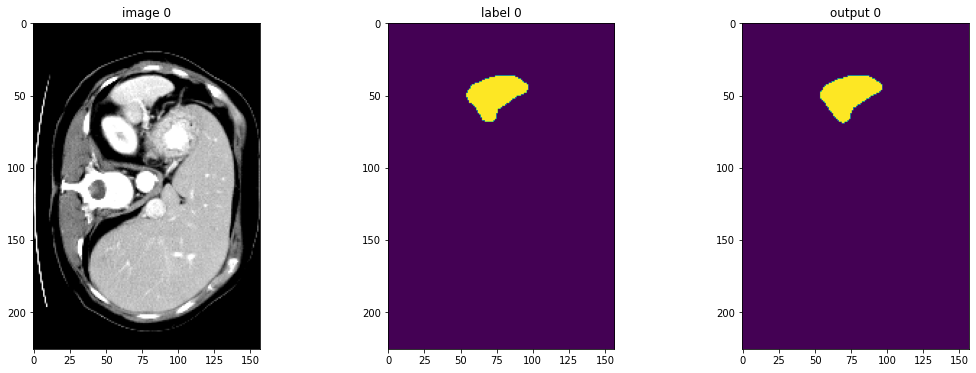

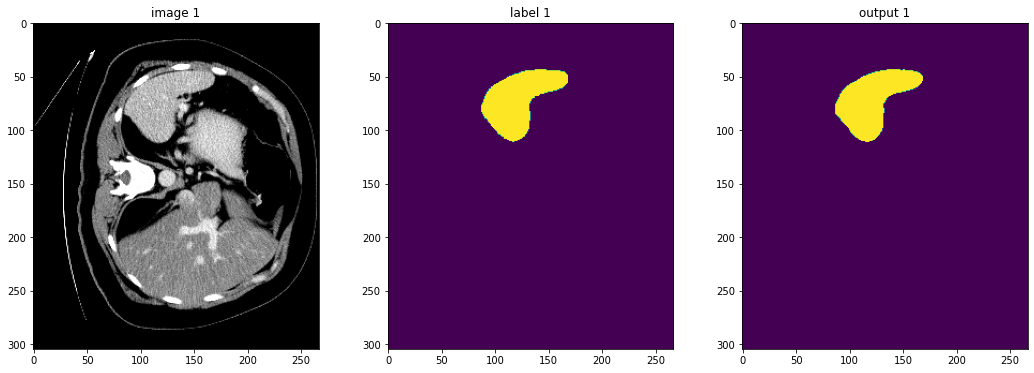

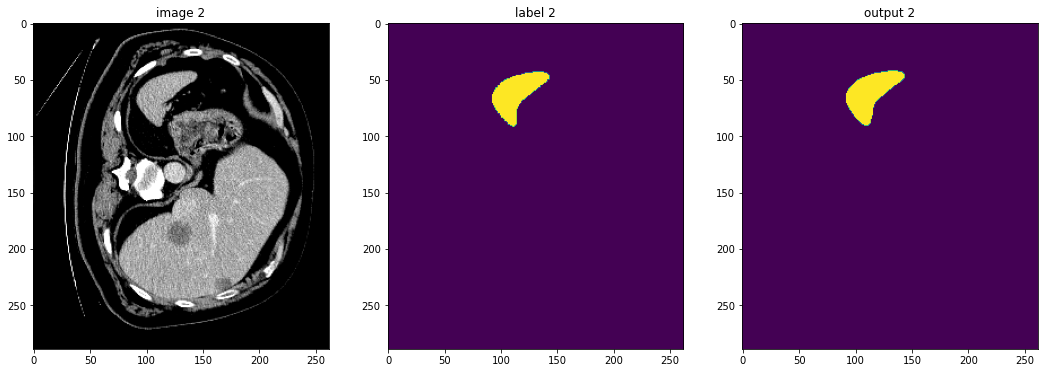

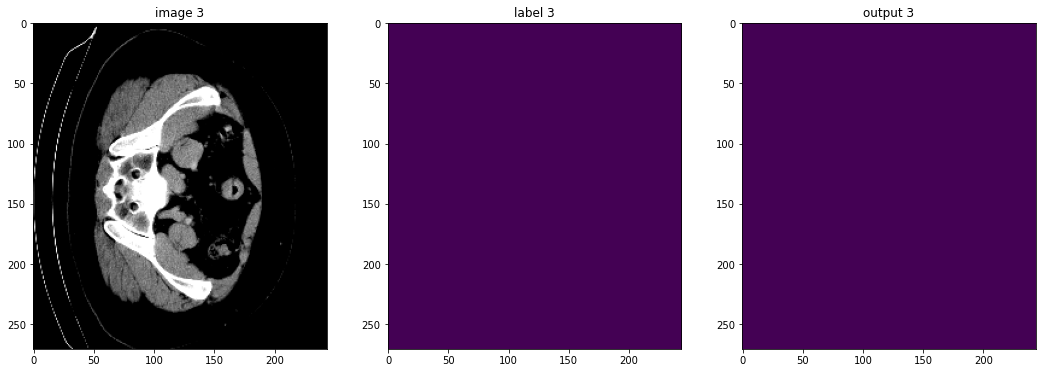

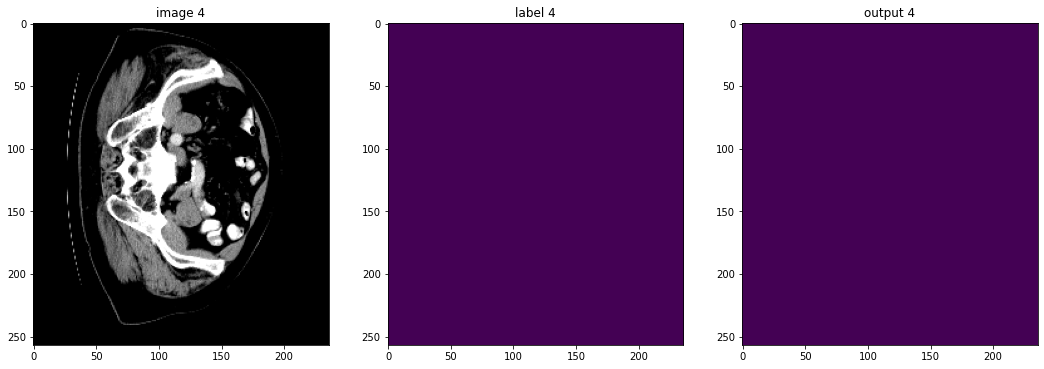

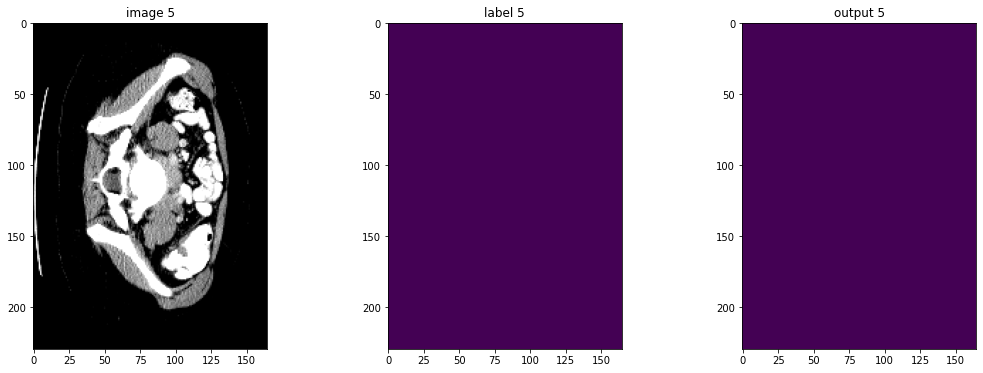

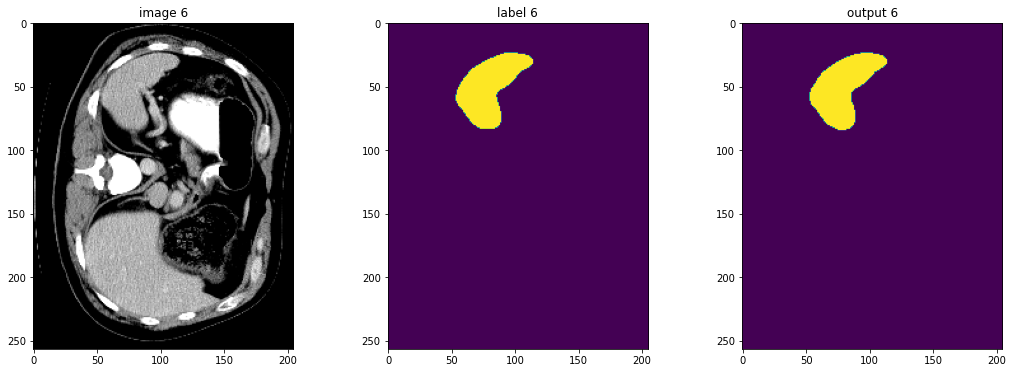

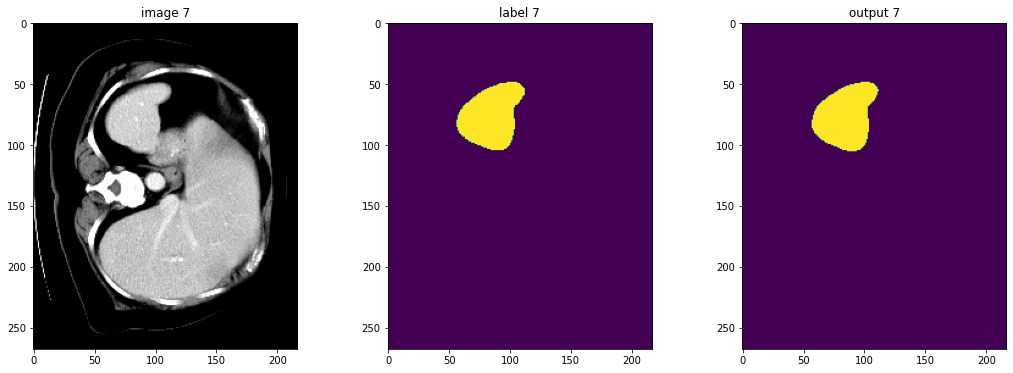

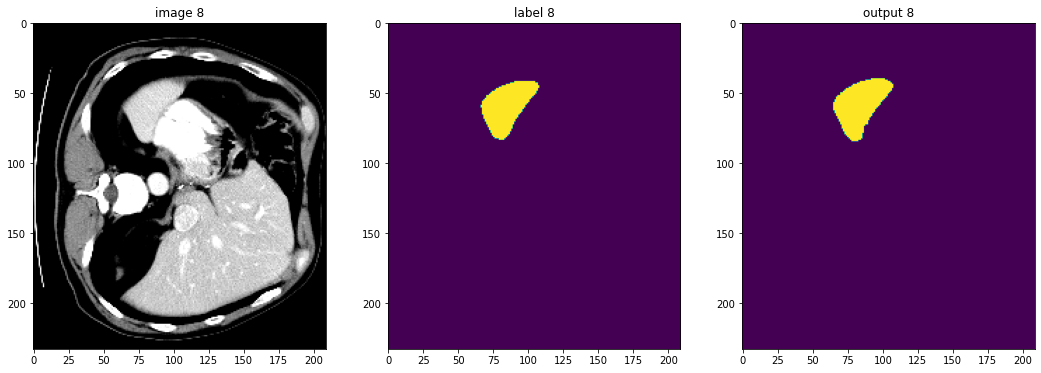

In [19]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)